In [24]:
import os, re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from transformers import BertTokenizer, TFBertForMaskedLM, BertConfig

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')
num_hidden_layers = 12
hidden_size = 768

model.bert.embeddings.trainable = False
unfreeze_layer_count = 6
for layer in model.bert.encoder.layer[:-unfreeze_layer_count]:
    layer.trainable = False

model.load_weights(f'drive/MyDrive/frz_layer_{unfreeze_layer_count}.h5')


# model_config = BertConfig.from_pretrained('bert-base-uncased')
# model_config.num_attention_heads = 6   # Default is 12
# num_hidden_layers = 6
# model_config.num_hidden_layers = num_hidden_layers     # Default is 12
# hidden_size = 768
# model_config.hidden_size = hidden_size         # Default is 768
# model_config.hidden_dropout_prob = 0.2  # Default is 0.1

# model = TFBertForMaskedLM(model_config)

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [28]:
input_ids = tokenizer("Hello, my dog is cute", return_tensors="tf")["input_ids"]
input_ids

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]],
      dtype=int32)>

In [29]:
outputs = model(input_ids, labels=input_ids, output_hidden_states=True)

# # Load model weights
# model.load_weights('drive/MyDrive/low_capacity_fine_tuned_model_weights_768_kw.h5')
# print('Model Loaded!')

outputs[2][num_hidden_layers].shape

TensorShape([1, 8, 768])

In [30]:
# 'drive/MyDrive/ML Training Corpus/RecommendationExtractions_II'

recomm_df = pd.read_csv('https://raw.githubusercontent.com/ColumbiaCysyphus/ml-dev/shubham-dev/summer_2022/cleaned_recs.csv', usecols=[1, 2])
recomm_df = recomm_df.dropna(how='any')
recomm_df.head(3)

,Document File Name,Recommendation text
0,GOVPUB-C13-e1840672bcc4d823d5a2b11dcb45d280.pdf,When evaluating IT products and services that ...
1,GOVPUB-C13-e1840672bcc4d823d5a2b11dcb45d280.pdf,Organizations developing their own custom secu...
2,GOVPUB-C13-e1840672bcc4d823d5a2b11dcb45d280.pdf,"Using CVE, CCE, and CPE names supports interop..."


In [31]:
recomm_sentences = []

for item in list(recomm_df['Recommendation text']):
  item = item.replace('\n', ' ').strip()
  item = re.sub("\s\s+", " ", item)
  item = re.sub(r'\.+', ".", item)

  item_sentence = sent_tokenize(item)
  recomm_sentences += item_sentence

len(recomm_sentences)

113

In [32]:
non_recomm_df = pd.read_csv('CYsyphus NonRecommendations.csv', header=None)
non_recomm_df.columns = ['name', 'sentence']
non_recomm_df = non_recomm_df.dropna(how='all')
non_recomm_df.head(3)

,name,sentence
0,NIST-CSF-bus_case-rev-17.21.pdf,An effective cybersecurity program involves a ...
1,NaN,The CIS Critical Security Controls (CIS Contro...
2,NaN,Effective information security reduces these r...


In [33]:
non_recomm_sentences = []

for item in list(non_recomm_df.sentence):
  item = item.replace('\n', ' ').strip()
  item = re.sub("\s\s+", " ", item)
  item = re.sub(r'\.+', ".", item)

  item_sentence = sent_tokenize(item)
  non_recomm_sentences += item_sentence

len(non_recomm_sentences)

21

In [34]:
# def get_CLS_embedding(model, sent):
#   input_ids = tokenizer(sent, return_tensors="tf")["input_ids"]
#   outputs = model(input_ids, labels=input_ids, output_hidden_states=True)
#   sentence_embedding_every_token = outputs[2][num_hidden_layers][0]  # hidden states, final layer embedd, squeeze dim
#   CLS_embedding = sentence_embedding_every_token[0]  # CLS as the first token
#   return CLS_embedding

In [35]:
def get_sentence_embedding(model, sent):
  input_ids = tokenizer(sent, return_tensors="tf")["input_ids"]
  outputs = model(input_ids, labels=input_ids, output_hidden_states=True)
  sentence_embedding_every_token = outputs[2][num_hidden_layers][0]
  sentence_embedding = tf.reduce_mean(sentence_embedding_every_token, 0)
  return sentence_embedding

In [36]:
recomm_len = len(recomm_sentences)
non_recomm_len = len(non_recomm_sentences)

original_model = TFBertForMaskedLM.from_pretrained('bert-base-uncased')

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [37]:
recomm_mat = np.zeros((recomm_len, hidden_size)) 
recomm_mat_original_bert = np.zeros((recomm_len, 768))

for i in tqdm(range(recomm_len)):
  recomm_mat[i, :] = get_sentence_embedding(model, recomm_sentences[i])
  recomm_mat_original_bert[i, :] = get_sentence_embedding(original_model, recomm_sentences[i])

100%|██████████| 113/113 [03:21<00:00,  1.78s/it]


In [38]:
non_recomm_mat = np.zeros((non_recomm_len, hidden_size))
non_recomm_mat_original_bert = np.zeros((non_recomm_len, 768))

for i in tqdm(range(non_recomm_len)):
  non_recomm_mat[i, :] = get_sentence_embedding(model, non_recomm_sentences[i])
  non_recomm_mat_original_bert[i, :] = get_sentence_embedding(original_model, non_recomm_sentences[i])

100%|██████████| 21/21 [00:33<00:00,  1.61s/it]


In [39]:
from sklearn.metrics.pairwise import cosine_similarity

In [40]:
# Recommendation Similarity

fine_tuned_sim = cosine_similarity(recomm_mat)
original_sim = cosine_similarity(recomm_mat_original_bert)

print(fine_tuned_sim.shape, original_sim.shape)

diff = fine_tuned_sim - original_sim
print(np.mean(diff))

(113, 113) (113, 113)
-0.03856161039851504


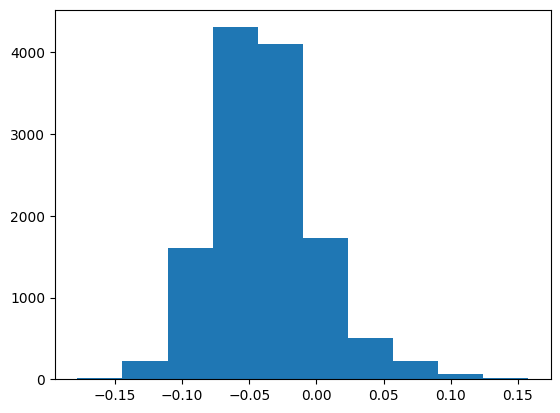

In [41]:
plt.hist(diff.flatten())
plt.show()

In [42]:
# Non-Recommendation Similarity

fine_tuned_sim_non = cosine_similarity(non_recomm_mat)
original_sim_non = cosine_similarity(non_recomm_mat_original_bert)

print(fine_tuned_sim_non.shape, original_sim_non.shape)

diff_non = fine_tuned_sim_non - original_sim_non
print(np.mean(diff_non))

(21, 21) (21, 21)
-0.03969369092083694


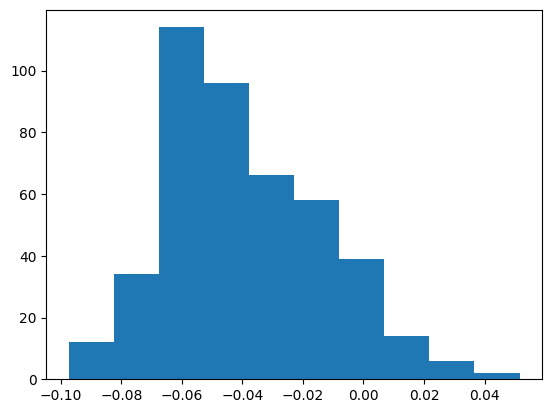

In [43]:
plt.hist(diff_non.flatten())
plt.show()

In [44]:
# Recommendation & Non-Recommendation Similarity

fine_tuned_sim_two_class = cosine_similarity(recomm_mat, non_recomm_mat)
original_sim_two_class = cosine_similarity(recomm_mat_original_bert, non_recomm_mat_original_bert)

print(fine_tuned_sim_two_class.shape, original_sim_two_class.shape)

diff_two_class = fine_tuned_sim_two_class - original_sim_two_class
print(np.mean(diff_two_class))

(113, 21) (113, 21)
-0.03644059739573823


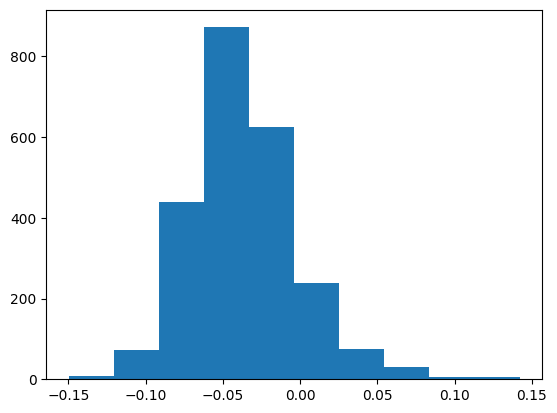

In [45]:
plt.hist(diff_two_class.flatten())
plt.show()